<h1><center> Facial Emotion Recognition - Preprocessing </center></h1>
<center> A project for the French Employment Agency </center>
<center> Telecom ParisTech 2018-2019 </center>

# I. Context

The aim of this notebook is to explore facial emotion recognition techniques from a live webcam video stream. 

The data set used for training is the Kaggle FER2013 emotion recognition data set : https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The models explored include :
- Manual filters 
- Deep Learning Architectures
- DenseNet Inspired Architectures

This model will be combined with voice emotion recongition as well as psychological traits extracted from text inputs, and should provide a benchmark and a deep analysis of both verbal and non-verbal insights for candidates seeking for a job and their performance during an interview.

# II. General imports

Versions used :

In [3]:
!pip install xgboost

     |████████████████████████████████| 1.3 MB 5.6 MB/s eta 0:00:01


In [5]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

# III. Import datas

In [6]:
path = '/Users/aryasoni/Documents/GitHub/AI-Interview/Video/Dataset/'
local_path = '/Users/aryasoni/Documents/GitHub/AI-Interview/Video/Dataset/'

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

#Reading the dataset
dataset = pd.read_csv(local_path + 'fer2013.csv')

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
dataset['pixels'] = dataset['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [8]:
dataset.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


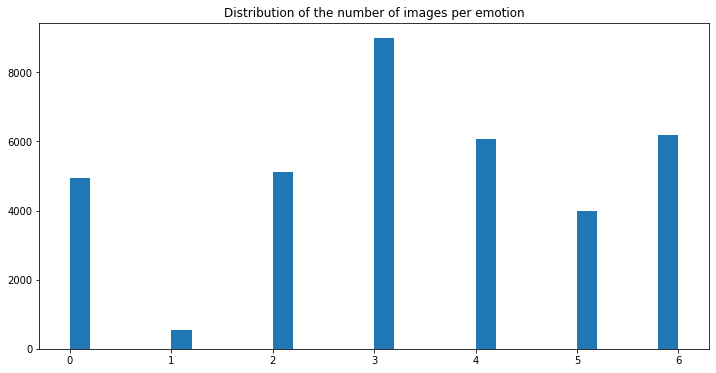

In [9]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

In [10]:
train.shape

(28709, 3)

In [11]:
test.shape

(3589, 3)

# IV. Create the data set

In [12]:
shape_x = 48
shape_y = 48

In [13]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values

X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

X = dataset.iloc[:,1].values
y = dataset.iloc[:,0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

X = np.reshape(X, (X.shape[0],48,48,1))
y = np.reshape(y, (y.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [14]:
# Change to float datatype
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X = X.astype('float32')

# Scale the data to lie between 0 to 1
X_train /= 255
X_test /= 255
X /= 255

# Change the labels from integer to categorical data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y = to_categorical(y)

# V. Define the number of classes

In [15]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  2
Output classes :  [0. 1.]


In [16]:
#Defining labels 
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

TypeError: only size-1 arrays can be converted to Python scalars

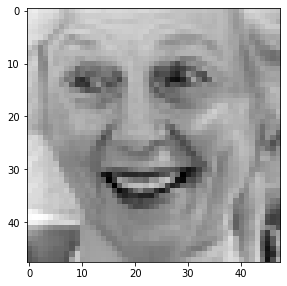

In [18]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))

# VI. Save the dataframes

In [19]:
np.save(local_path + 'X_train', X_train)
np.save(local_path + 'X_test', X_test)
np.save(local_path + 'X', X)
np.save(local_path + 'y_train', y_train)
np.save(local_path + 'y_test', y_test)
np.save(local_path + 'y', y)

# VII. Feature Importance

In [21]:
path = '/Users/aryasoni/Documents/GitHub/AI-Interview/Video/Dataset/npy/'
local_path = '/Users/aryasoni/Documents/GitHub/AI-Interview/Video/Dataset/npy/'

X_train = np.load(local_path + "X_train.npy")
X_test = np.load(local_path + "X_test.npy")
y_train = np.load(local_path + "y_train.npy")
y_test = np.load(local_path + "y_test.npy")

shape_x = 48
shape_y = 48
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [22]:
model = OneVsRestClassifier(XGBClassifier())
model.fit(X_train.reshape(-1,48*48*1)[:5000], y_train[:5000])

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:37:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:38:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:38:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:39:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
     

In [23]:
gray = cv2.cvtColor(model.feature_importances_.reshape(shape_x, shape_y,3), cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,8))
sns.heatmap(gray)
plt.show()

AttributeError: 'OneVsRestClassifier' object has no attribute 'feature_importances_'

# VIII. Sources

- Visualization : https://github.com/JostineHo/mememoji/blob/master/data_visualization.ipynb
- State of the art Architecture : https://github.com/amineHorseman/facial-expression-recognition-using-cnn
- Eyes Tracking : https://www.pyimagesearch.com/2017/04/24/eye-blink-detection-opencv-python-dlib/
- Face Alignment : https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
- C.Pramerdorfer,  and  M.Kampel.Facial  Expression  Recognition  using  Con-volutional  Neural  Networks:  State  of  the  Art.  Computer  Vision  Lab,  TU  Wien. https://arxiv.org/pdf/1612.02903.pdf
- A Brief Review of Facial Emotion Recognition Based
on Visual Information : https://www.mdpi.com/1424-8220/18/2/401/pdf
- Going deeper in facial expression recognition using deep neural networks : https://ieeexplore.ieee.org/document/7477450
- Emotional Deep Alignment Network paper : https://arxiv.org/abs/1810.10529
- Emotional Deep Alignment Network github : https://github.com/IvonaTau/emotionaldan